Use Census Data API to request Time Series Economic Indicators - Quarterly Summary of State and Local Taxes
QTAXCAT3: latest state tax collections by state and type of tax

T01: property taxes

T09: general sales and gross receipts taxes

T15: public utilities tax

All cell values in millions of dollars
https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id,error_data&category_code=QTAXCAT3&seasonally_adj&data_type_code&time=from+2010



In [8]:
import urllib.request, urllib.parse, urllib.error
import json
import requests
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
import numpy as np
import seaborn as sns

My intuition is that the state that has a higher GDP will see their muni bond perform better, therefore I downloaded data from FRED and looked at each state's GDP for the past ten years and found three states of my interest: California with the highest GDP, Vermont with the lowest, and Massachusetts where I reside. 

In [9]:
GDPdf = pd.read_csv('stateGDP.csv')
GDPdf.head()
GDPdf_new = GDPdf.drop("DATE", axis=1, inplace=False)
print(GDPdf_new.idxmax(axis = 1),GDPdf_new.idxmin(axis = 1))

0     CANQGSP
1     CANQGSP
2     CANQGSP
3     CANQGSP
4     CANQGSP
5     CANQGSP
6     CANQGSP
7     CANQGSP
8     CANQGSP
9     CANQGSP
10    CANQGSP
11    CANQGSP
12    CANQGSP
13    CANQGSP
14    CANQGSP
15    CANQGSP
16    CANQGSP
17    CANQGSP
18    CANQGSP
19    CANQGSP
20    CANQGSP
21    CANQGSP
22    CANQGSP
23    CANQGSP
24    CANQGSP
25    CANQGSP
26    CANQGSP
27    CANQGSP
28    CANQGSP
29    CANQGSP
30    CANQGSP
31    CANQGSP
32    CANQGSP
33    CANQGSP
34    CANQGSP
35    CANQGSP
36    CANQGSP
37    CANQGSP
38    CANQGSP
39    CANQGSP
dtype: object 0     VTNQGSP
1     VTNQGSP
2     VTNQGSP
3     VTNQGSP
4     VTNQGSP
5     VTNQGSP
6     VTNQGSP
7     VTNQGSP
8     VTNQGSP
9     VTNQGSP
10    VTNQGSP
11    VTNQGSP
12    VTNQGSP
13    VTNQGSP
14    VTNQGSP
15    VTNQGSP
16    VTNQGSP
17    VTNQGSP
18    VTNQGSP
19    VTNQGSP
20    VTNQGSP
21    VTNQGSP
22    VTNQGSP
23    VTNQGSP
24    VTNQGSP
25    VTNQGSP
26    VTNQGSP
27    VTNQGSP
28    VTNQGSP
29    VTNQGSP
30    

I used the S&P Municipal Bond Index as a benchmark for these states' muni bond performances. It is a broad, market value-weighted index that seeks to measure the performance of bonds issued within Massachusetts. The time series plot shows strong positive correlation between states. The performances of CA and VT bonds were almost identical, yet MA has been underperforming the other two since 2014. 

Date - 0.0 missing
Index - 0.0 missing


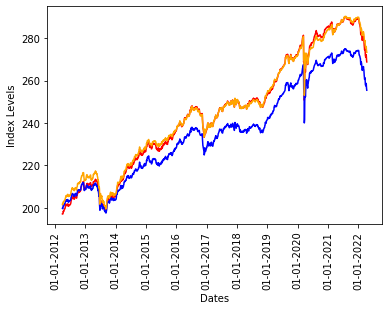

In [11]:
CAdf = pd.read_csv('CAmuni.csv')
CAdf['Date'] = pd.to_datetime(CAdf['Date'])
#CAdf.head()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
CAdf['Date'] = pd.to_datetime(CAdf['Date'])
#Check for missing data
for col in CAdf.columns:
    pct_missing = np.mean(CAdf[col].isnull())
    print('{} - {} missing'.format(col, pct_missing))
CAdate = CAdf['Date']
CAindex = CAdf['Index']
CAdatelst = list(CAdate)
CAindexlst = list(CAindex)

#Vermont Municipal Bond
VTmuni = pd.read_csv('VTmuni.csv')
VTindex = VTmuni['Index']
VTindexlst = []
VTindexlst = list(VTindex)

#Massachusetts Municipal Bond
MAmuni = pd.read_csv('MAmuni.csv')
MAindex = MAmuni['Index']
MAindexlst = []
MAindexlst = list(MAindex)

#Time Series plot
plt.plot(CAdatelst, CAindexlst, color = 'red')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.plot(CAdatelst, MAindexlst, color = 'blue')
plt.plot(CAdatelst, VTindexlst, color = 'orange')
plt.xlabel('Dates')
plt.ylabel('Index Levels')
plt.xticks(rotation = 90)
plt.show()


My hypothesis is that the tax revenue of these three states would have a high correlation with their muni bond performances because these bonds are backed by the “full faith and credit” of the issuer, which has the power to tax residents to pay bondholders. I used Census Data API to request Time Series Economic Indicators - Quarterly Summary of State and Local Taxes 

QTAXCAT3: latest state tax collections by state and type of tax

T01: property taxes

T09: general sales and gross receipts taxes

T15: public utilities tax

All cell values in millions of dollars

In [14]:
def only_dict(data):
    return ast.literal_eval(data)

In [15]:
#Define a function for correlation between T01 and muni bond index
def T01corr(state):
    url = 'https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T01&geo_level_code='+state+'&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012'
    print('Retrieving', url)
    api_data = urllib.request.urlopen(url)
    data = api_data.read().decode()
    print('Retrieved', len(data),'characters')

    try: 
        js = json.loads(data)
    except:
        js = None
    if not js:
        print('====Failure To Retrieve====')
        
    statedata = only_dict(data)
    datelst = []
    state_T01 = []
    for i in range(1,len(statedata)):
        state_T01.append(float(statedata[i][0]))
    for j in range(1,len(statedata)):
        datelst.append(statedata[j][-1])

    statedf = pd.read_csv(state + 'muni.csv')
    date = statedf['Date']
    stateindex = statedf['Index']
    daily = list(date)
    stateindexlst = list(stateindex)    
    
    
    statedict = {daily[i]: stateindexlst[i] for i in range(len(daily))} #dictionary comprehension

    #convert bond index data to quarterly by taking the number on the last day of each quarter.
    
    #find all dates in the last month of a quarter in each year
    lst1=[]
    for year in range(2012,2022):
        for k in range(len(daily)):
            if str(year) + '-03' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-06' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-09' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-12' == daily[k][:7]:
                lst1.append(daily[k])
                
    #find the last day of a quarter
    Qends = []
    for v in range(len(lst1)-1):
        if lst1[v][:7] != lst1[v+1][:7]:
            Qends.append(lst1[v])
    Qends.append(lst1[-1])        #add one missing date

    #find the index value at these end of quarter dates
    Qend_val=[]
    for d in range(len(Qends)):
        Qend_val.append(statedict[Qends[d]])
    print('\nNumber of dates matched:', len(Qend_val) == len(datelst))  #See if the number of dates matches
    statecorr = pd.DataFrame(list(zip(state_T01,Qend_val)), columns = ['property tax','bond index'])
    sns.regplot(x = 'property tax', y = 'bond index', data = statecorr)
    print(statecorr.corr(method = 'pearson'))

Retrieving https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T01&geo_level_code=CA&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012
Retrieved 2225 characters

Number of dates matched: True
              property tax  bond index
property tax      1.000000    0.924369
bond index        0.924369    1.000000


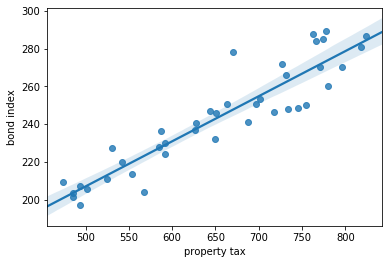

In [16]:
#CA
T01corr('CA')

In [ ]:
T01corr('VT')

In [ ]:
#MA
T01corr('MA')

The graphs for three states show strong correlation between property taxes and muni bond index levels in California, but there seems to be erroneous data for property taxes in VT and MA, wiht lots of 0s and 1s in values. According to *Property Tax Facts&Figures - FY2021* from City of Boston Assessing Department, total value of property tax in FY2021 was over 190 billion in the City of Boston.

In [17]:
#Define a function for T15corr
def T15corr(state):
    url = 'https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T15&geo_level_code='+state+'&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012'
    print('Retrieving', url)
    api_data = urllib.request.urlopen(url)
    data = api_data.read().decode()
    print('Retrieved', len(data),'characters')

    try: 
        js = json.loads(data)
    except:
        js = None
    if not js:
        print('====Failure To Retrieve====')
        
    statedata = only_dict(data)
    datelst = []
    state_T15 = []
    for i in range(1,len(statedata)):
        state_T15.append(float(statedata[i][0]))
    for j in range(1,len(statedata)):
        datelst.append(statedata[j][-1])

    statedf = pd.read_csv(state + 'muni.csv')
    date = statedf['Date']
    stateindex = statedf['Index']
    daily = list(date)
    stateindexlst = list(stateindex)    
    
    
    statedict = {daily[i]: stateindexlst[i] for i in range(len(daily))}

    #find all dates in the last month of a quarter in each year
    lst1=[]
    for year in range(2012,2022):
        for k in range(len(daily)):
            if str(year) + '-03' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-06' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-09' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-12' == daily[k][:7]:
                lst1.append(daily[k])
                
    #find the last day of a quarter
    Qends = []
    for v in range(len(lst1)-1):
        if lst1[v][:7] != lst1[v+1][:7]:
            Qends.append(lst1[v])
    Qends.append(lst1[-1])        #add one missing date

    #find the index value at these end of quarter dates
    Qend_val=[]
    for d in range(len(Qends)):
        Qend_val.append(statedict[Qends[d]])
    print('\nNumber of dates matched:', len(Qend_val) == len(datelst))  #See if the number of dates matches
    statecorr = pd.DataFrame(list(zip(state_T15,Qend_val)), columns = ['public utilities tax','bond index'])
    sns.regplot(x = 'public utilities tax', y = 'bond index', data = statecorr)
    print(statecorr.corr(method = 'pearson'))


Retrieving https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T15&geo_level_code=CA&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012
Retrieved 2223 characters

Number of dates matched: True
                      public utilities tax  bond index
public utilities tax              1.000000   -0.128167
bond index                       -0.128167    1.000000


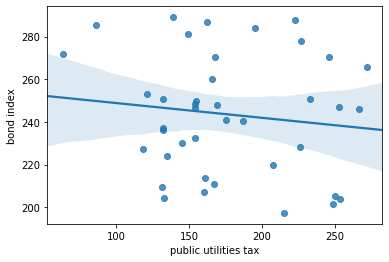

In [18]:
T15corr('CA')

In [ ]:
T15corr('VT')

In [ ]:
T15corr('MA')

The three graphs show no particular pattern between public utilities tax and muni bond index. Once again, there are many 0s in VT's data. MA shows a constant public utilities tax of about 6 million dollars.  

In [19]:
def T09corr(state):
    url = 'https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T09&geo_level_code='+state+'&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012'
    print('Retrieving', url)
    api_data = urllib.request.urlopen(url)
    data = api_data.read().decode()
    print('Retrieved', len(data),'characters')

    try: 
        js = json.loads(data)
    except:
        js = None
    if not js:
        print('====Failure To Retrieve====')
        
    statedata = only_dict(data)
    datelst = []
    state_T09 = []
    for i in range(1,len(statedata)):
        state_T09.append(float(statedata[i][0]))
    for j in range(1,len(statedata)):
        datelst.append(statedata[j][-1])

    statedf = pd.read_csv(state + 'muni.csv')
    date = statedf['Date']
    stateindex = statedf['Index']
    daily = list(date)
    stateindexlst = list(stateindex)    
    
    
    statedict = {daily[i]: stateindexlst[i] for i in range(len(daily))}

    #find all dates in the last month of a quarter in each year
    lst1=[]
    for year in range(2012,2022):
        for k in range(len(daily)):
            if str(year) + '-03' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-06' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-09' == daily[k][:7]:
                lst1.append(daily[k])
            elif str(year) + '-12' == daily[k][:7]:
                lst1.append(daily[k])
                
    #find the last day of a quarter
    Qends = []
    for v in range(len(lst1)-1):
        if lst1[v][:7] != lst1[v+1][:7]:
            Qends.append(lst1[v])
    Qends.append(lst1[-1])        #add one missing date

    #find the index value at these end of quarter dates
    Qend_val=[]
    for d in range(len(Qends)):
        Qend_val.append(statedict[Qends[d]])
    print('\nNumber of dates matched:', len(Qend_val) == len(datelst))  #See if the number of dates matches
    statecorr = pd.DataFrame(list(zip(state_T09,Qend_val)), columns = ['general sales tax','bond index'])
    sns.regplot(x = 'general sales tax', y = 'bond index', data = statecorr)
    print(statecorr.corr(method = 'pearson'))


Retrieving https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T09&geo_level_code=CA&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012
Retrieved 2281 characters

Number of dates matched: True
                   general sales tax  bond index
general sales tax           1.000000    0.744505
bond index                  0.744505    1.000000


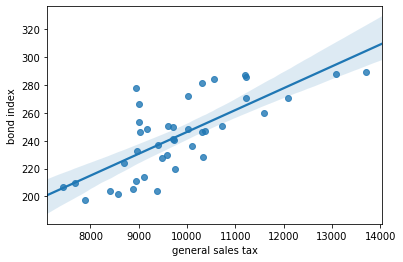

In [20]:
T09corr('CA')

In [ ]:
T09corr('VT')

In [ ]:
T09corr('MA')

There is strong positive correlation between general sales and gross receipts taxes and muni bond performance. I compared T09 of the three states for the past 10 years to see if it explains MA's underperformance since 2014. 

In [ ]:
url = 'https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T09&geo_level_code=CA&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012'
api_data = urllib.request.urlopen(url)
CAdata = api_data.read().decode()

CA_dict = only_dict(CAdata)
datelst = []
CA_T09 = []
for i in range(1,len(CA_dict)):
    CA_T09.append(float(CA_dict[i][0]))
for j in range(1,len(CA_dict)):
    datelst.append(CA_dict[j][-1])

url = 'https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T09&geo_level_code=VT&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012'
api_data = urllib.request.urlopen(url)
VTdata = api_data.read().decode()

VT_dict = only_dict(VTdata)
VT_T09 = []
for i in range(1,len(VT_dict)):
    VT_T09.append(float(VT_dict[i][0]))

    
url = 'https://api.census.gov/data/timeseries/eits/qtax?get=cell_value,time_slot_id&data_type_code=T09&geo_level_code=MA&category_code=QTAXCAT3&seasonally_adj=no&time=from+2012'
api_data = urllib.request.urlopen(url)
MAdata = api_data.read().decode()

MA_dict = only_dict(MAdata)
MA_T09 = []
for i in range(1,len(MA_dict)):
    MA_T09.append(float(MA_dict[i][0]))
    

In [ ]:
# plt.plot(datelst, CA_T09, color = 'red')
plt.plot(datelst, MA_T09, color = 'blue')
plt.plot(datelst, VT_T09, color = 'orange')
plt.xlabel('Dates')
plt.ylabel('T09')
plt.xticks(rotation = 90)
plt.show()

Next, I investigate 